# fbprophet 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

## Dataset 
* MACD 지표 추가(MACD, MACDS, MACDO)
* Open

## Model
* fbprophet으로 학습해야하는 대상 
    1. MACDS, MACDO: 두개 지표가 크로스되는 포인트에 매수/매도, 즉 시점에 대한 선택을 위한 학습 
    2. Open: Open 가격으로 매수/매도, 즉 매수/매도 가격 선택을 위한 학습
    3. 

## Trading 전략
* open가를 명확히하지 않아도, 실제로 제출하는 정답지에는 buy_quantity와 sell_time이므로 예측한 open가에 의존하지 않고, MACD로 sell_time을 보정할 수 있다. 그리고 buy_time때도 시점에 대한 조율을 못하니까 예측한 MACD에서 골든크로스가 있으면 매도를 진행하도록 한다. 
* MACD(MACD, MACD 오실레이터, MACD 시그널) 활용: 아래 그림에서 MACD는 파란색 실선, 그리고 시그널이 빨간색 실선이면, 오실레이터는 파랑과 빨강 막대로 표현된 그래프이다. 각 값들이 크로스되면서, 오실레이터가 음봉(파란색)에 해당하면 매도 포인트(데드크로스)가 되는 것이고, 매수 포인트때 골든크로스에 해당하면 매수를 진행한다. 
    * MACD 계산식: 
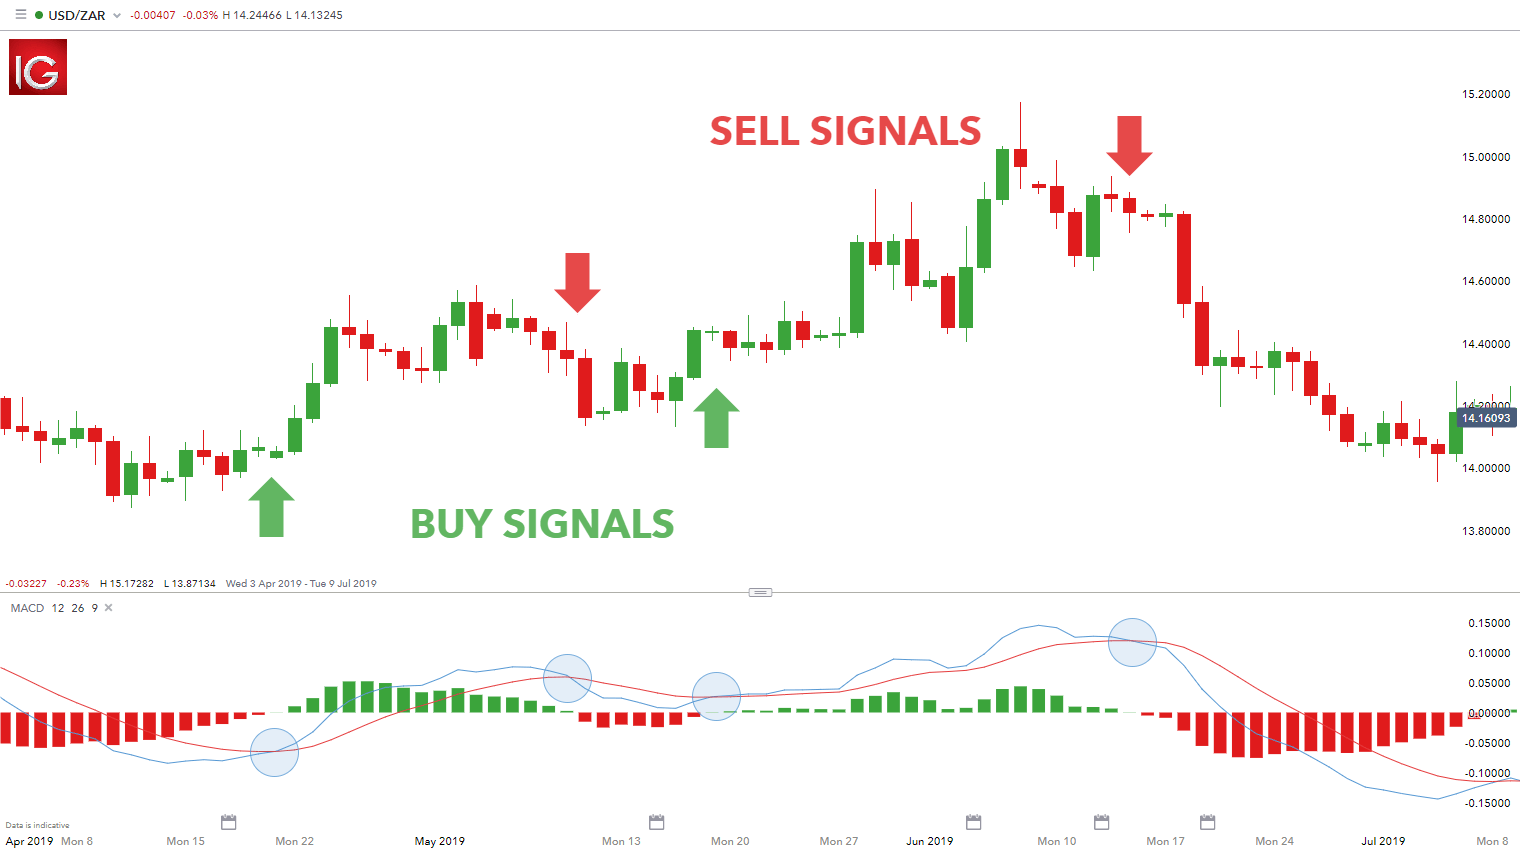
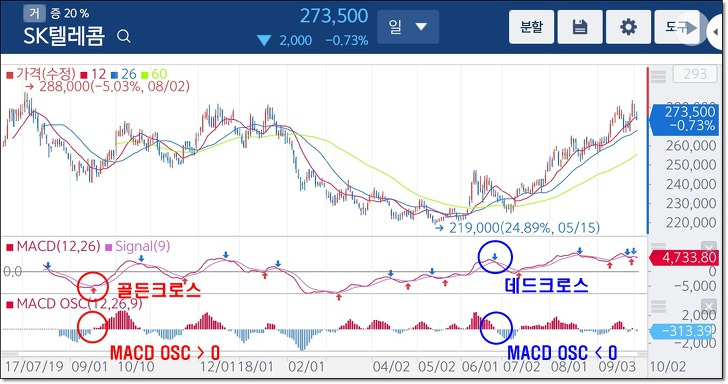

In [34]:
# !pip install statsmodels==0.11.1
# !pip install fbprophet
# !pip install plotly

# 1. Library Import

In [35]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
from plotly import tools 
import plotly.offline as offline 
import plotly.graph_objs as go 
warnings.filterwarnings("ignore")

In [36]:
gc.collect();

# 2. 데이터 불러오기

## 1) read_csv

In [37]:
data_path = os.getenv('HOME') + '/ModuWay/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

* sample_id : 개별 샘플의 인덱스
* time : x_df는 0분 ~ 1379분, y_df는 0분 ~ 119분의 값을 갖습니다. 동일한 샘플 내 시간 정보
* coin_index : 10가지 종류의 코인에 대한 비식별화 인덱스 (0 ~9)
* open : open price
* high : high price
* low : low price
* close : close price
* volume : 거래량
* quote_av : quote asset volume
* trades : 거래 건 수
* tb_base_av : taker buy base asset volume
* tb_quote_av : taker buy quote asset volume

In [38]:
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [39]:
# # train_x_macd_df, train_y_macd_df, test_x_macd_df 저장
# train_x_df.to_csv(data_path + '/train_x_macd_df.csv')
# train_y_df.to_csv(data_path + '/train_y_macd_df.csv')
# test_x_df.to_csv(data_path + '/test_x_macd_df.csv')

In [40]:
macd_train_x_df = pd.read_csv(data_path  + "/train_x_macd_df.csv")
macd_train_y_df = pd.read_csv(data_path  + "/train_y_macd_df.csv")
macd_test_x_df = pd.read_csv(data_path  + "/test_x_macd_df.csv")

In [41]:
macd_train_x_df.head()

,Unnamed: 0,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594,1.010004,1.010004,1.010004,1.010004,0.000000,0.000000,0.000000
1,1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000,1.009906,1.009906,1.009898,1.009902,-0.000004,-0.000002,-0.000002
2,2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808,1.010004,1.010004,1.010016,1.010009,0.000007,0.000001,0.000005
3,3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875,1.010298,1.010298,1.010383,1.010337,0.000047,0.000017,0.000030
4,4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000,1.010279,1.010279,1.010334,1.010305,0.000029,0.000020,0.000008


In [42]:
macd_train_y_df.head()

,Unnamed: 0,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688,1.000588,1.000588,1.000588,1.000588,0.000000,0.000000,0.000000
1,1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328,1.000883,1.000883,1.000907,1.000894,0.000013,0.000007,0.000006
2,2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641,1.000981,1.000981,1.001012,1.000996,0.000017,0.000011,0.000006
3,3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250,1.001079,1.001079,1.001126,1.001101,0.000025,0.000016,0.000009
4,4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844,1.000902,1.000902,1.000874,1.000891,-0.000018,0.000006,-0.000024


In [43]:
macd_test_x_df.head()

,Unnamed: 0,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.96875,182543.687500,332.671570,287449.968750,107758.375000,1.006090,1.006090,1.006090,1.006090,0.000000,0.000000,0.000000
1,1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.37500,309019.750000,407.790955,560290.250000,210005.125000,1.005862,1.005862,1.005843,1.005853,-0.000010,-0.000006,-0.000005
2,2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.56250,179301.843750,276.332031,214270.265625,80283.554688,1.005697,1.005697,1.005657,1.005678,-0.000021,-0.000012,-0.000009
3,3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.84375,125305.117188,166.335785,56401.246094,21135.490234,1.005721,1.005721,1.005700,1.005711,-0.000010,-0.000012,0.000001
4,4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.68750,210316.796875,303.160370,138711.703125,52010.964844,1.005763,1.005763,1.005762,1.005761,0.000001,-0.000008,0.000009


In [44]:
macd_train_x_df.reset_index()
macd_train_x_df = macd_train_x_df[['sample_id', 'time', 'coin_index','open','high', 'low', 'close', 'volume', 'trades', \
                'sma7', 'sma25', 'ma_12', 'ma_26', 'macd', 'macds', 'macdo']]
macd_train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,trades,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,451.157288,1.010004,1.010004,1.010004,1.010004,0.000000,0.000000,0.000000
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,39.231071,1.009906,1.009906,1.009898,1.009902,-0.000004,-0.000002,-0.000002
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,58.846603,1.010004,1.010004,1.010016,1.010009,0.000007,0.000001,0.000005
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,431.541779,1.010298,1.010298,1.010383,1.010337,0.000047,0.000017,0.000030
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,176.539810,1.010279,1.010279,1.010334,1.010305,0.000029,0.000020,0.000008


In [45]:
macd_train_y_df.reset_index()
macd_train_y_df = macd_train_y_df[['sample_id', 'time', 'coin_index','open','high', 'low', 'close', 'volume', 'trades', \
                'sma7', 'sma25', 'ma_12', 'ma_26', 'macd', 'macds', 'macdo']]
macd_train_y_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,trades,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,137.308746,1.000588,1.000588,1.000588,1.000588,0.000000,0.000000,0.000000
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,294.233032,1.000883,1.000883,1.000907,1.000894,0.000013,0.000007,0.000006
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,58.846603,1.000981,1.000981,1.001012,1.000996,0.000017,0.000011,0.000006
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,137.308746,1.001079,1.001079,1.001126,1.001101,0.000025,0.000016,0.000009
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,666.928162,1.000902,1.000902,1.000874,1.000891,-0.000018,0.000006,-0.000024


In [46]:
macd_test_x_df.reset_index()
macd_test_x_df = macd_test_x_df[['sample_id', 'time', 'coin_index','open','high', 'low', 'close', 'volume', 'trades', \
                'sma7', 'sma25', 'ma_12', 'ma_26', 'macd', 'macds', 'macdo']]
macd_test_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,trades,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.96875,332.671570,1.006090,1.006090,1.006090,1.006090,0.000000,0.000000,0.000000
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.37500,407.790955,1.005862,1.005862,1.005843,1.005853,-0.000010,-0.000006,-0.000005
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.56250,276.332031,1.005697,1.005697,1.005657,1.005678,-0.000021,-0.000012,-0.000009
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.84375,166.335785,1.005721,1.005721,1.005700,1.005711,-0.000010,-0.000012,0.000001
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.68750,303.160370,1.005763,1.005763,1.005762,1.005761,0.000001,-0.000008,0.000009


## 2) numpy arrary로 변환하기

In [15]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [24]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [25]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



In [26]:
macd_train_x_array = df2d_to_array3d(macd_train_x_df)
macd_train_y_array = df2d_to_array3d(macd_train_y_df)
macd_test_x_array = df2d_to_array3d(macd_test_x_df)

In [27]:
print(f'''
train_x_array {macd_train_x_array.shape}
train_y_array {macd_train_y_array.shape}
test_x_array {macd_test_x_array.shape}
''')


train_x_array (7362, 1380, 14)
train_y_array (7362, 120, 14)
test_x_array (529, 1380, 14)



## MACD 시각화 

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

In [48]:
idx = 1030

In [49]:
index = train_x_df[train_x_df['sample_id']==idx].time.tolist()
type(index), len(index)

(list, 1380)

In [51]:
# loc 쓰기 귀찮아서 데이터 프레임으로.. 그냥 .. 때려..넣기? => 나중에 수정
sample_macd_x_df = pd.DataFrame()
sample_macd_x_df = macd_train_x_df[['sample_id','sma7', 'sma25','macd','macdo','macds']]
sample_macd_x_df.head()

,sample_id,sma7,sma25,macd,macdo,macds
0,0,1.010004,1.010004,0.000000,0.000000,0.000000
1,0,1.009906,1.009906,-0.000004,-0.000002,-0.000002
2,0,1.010004,1.010004,0.000007,0.000005,0.000001
3,0,1.010298,1.010298,0.000047,0.000030,0.000017
4,0,1.010279,1.010279,0.000029,0.000008,0.000020


In [52]:
sma7_lst = sample_macd_x_df['sma7'].loc[sample_macd_x_df['sample_id']==idx].tolist()
sma25_lst = sample_macd_x_df['sma25'].loc[sample_macd_x_df['sample_id']==idx].tolist()

In [53]:
print(len(sma25_lst) == len(sma7_lst)) # 차원 일치 여부 확인 
print(type(index) == type(sma7_lst)) # 형 일치 여부 확인 

True
True


In [54]:
index[0:2], sma7_lst[0:2] # 값 확인

([0, 1], [1.0661075115203915, 1.0664364099502597])

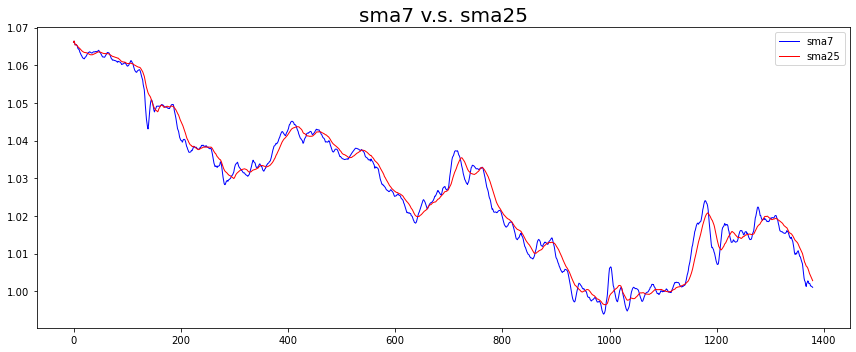

In [55]:
# Main chart - SMA_7 and SMA_25
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('sma7 v.s. sma25', fontsize=20)

ax.plot(index, sma7_lst, 'b', lw=1, label='sma7')
ax.plot(index, sma25_lst, 'r', lw=1, label='sma25')
ax.legend(loc='best')

fig.tight_layout()

In [62]:
macd_lst = sample_macd_x_df['macd'].loc[sample_macd_x_df['sample_id']==idx].tolist()
macds_lst = sample_macd_x_df['macds'].loc[sample_macd_x_df['sample_id']==idx].tolist()
macdo_lst = sample_macd_x_df['macdo'].loc[sample_macd_x_df['sample_id']==idx].tolist()

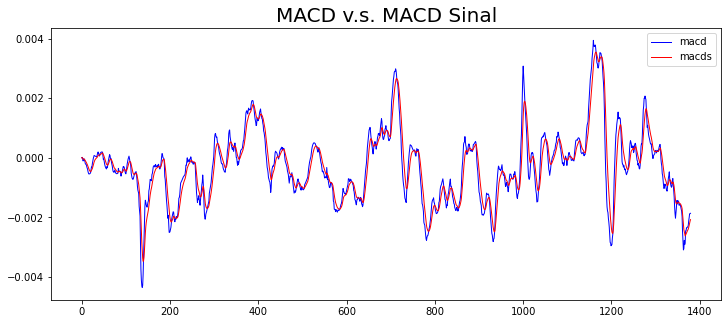

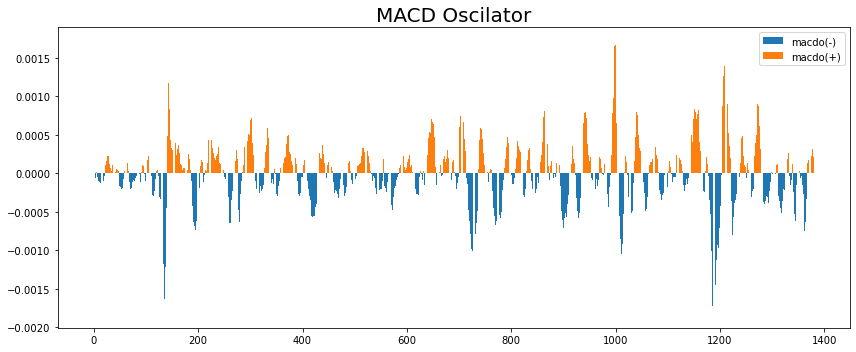

In [66]:
# index chart - MACD and MACDs
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('MACD v.s. MACD Sinal', fontsize=20)

ax.plot(index, macd_lst, 'b', lw=1, label='macd')
ax.plot(index, macds_lst, 'r', lw=1, label='macds')
ax.legend(loc='best')

# index chart - MACDo
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('MACD Oscilator', fontsize=20)

ax.bar(index, [0 if i > 0 else i for i in macdo_lst], lw=1, label='macdo(-)')
ax.bar(index, [0 if i < 0 else i for i in macdo_lst], lw=1, label='macdo(+)')
ax.legend(loc='best')

fig.tight_layout()

## 샘플 확인하기

In [ ]:
idx

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [ ]:
# open
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

In [ ]:
# sma25 - 25분 단위로 평균
plot_series(train_x_array[idx,:,10], train_y_array[idx,:,10])
plt.show()

In [ ]:
macd_x_series = train_x_array[idx,:,11]
macd_y_series = train_y_array[idx,:,11]
plt.plot(macd_x_series, label = 'input_series')
plt.plot(np.arange(len(macd_x_series), len(macd_x_series)+len(macd_y_series)),
         macd_y_series, label = 'output_series')

In [ ]:
x_series = train_x_array[idx,:,12]
y_series = train_y_array[idx,:,12]

series = x_series + y_series

# plt.plot(x_series, label = 'input_series')
# plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
#          y_series, label = 'output_series')

plt.plot(series)

In [ ]:
x_series = train_x_array[idx,:,13]
y_series = train_y_array[idx,:,13]

plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
         y_series, label = 'output_series')

## fbprophet 모델 학습

In [78]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [ ]:
macd_x_series = train_x_array[idx,:,11]
macd_y_series = train_y_array[idx,:,11]

macd_x_df = pd.DataFrame()
macd_x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, macd_x_series.shape[0]+1).tolist()]
macd_x_df['y'] = macd_y_series.tolist()

macd_x_df.head()

In [88]:
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
prophet.fit(macd_x_df)

In [89]:
# 120분 테스트 데이터를 예측합니다.
future_data = prophet.make_future_dataframe(periods=120, freq='min')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1495,2021-02-01 00:56:00,-0.004980,-0.006959,-0.002946
1496,2021-02-01 00:57:00,-0.004991,-0.007057,-0.002948
1497,2021-02-01 00:58:00,-0.005001,-0.007204,-0.002866
1498,2021-02-01 00:59:00,-0.005011,-0.007050,-0.003002
1499,2021-02-01 01:00:00,-0.005022,-0.007198,-0.002991


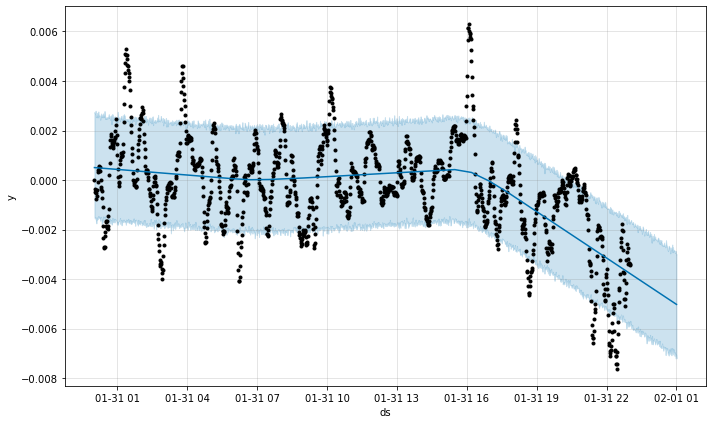

In [90]:
# 만들어진 데이터를 확인합니다.
fig1 = prophet.plot(forecast_data)

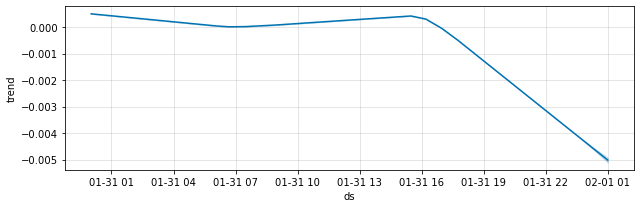

In [91]:
# 데이터의 추세를 확인합니다.
fig2 = prophet.plot_components(forecast_data)

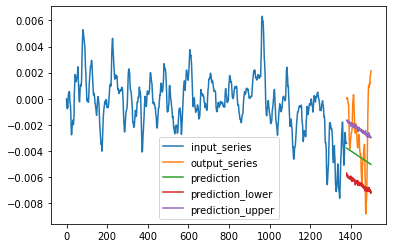

In [96]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
         y_series, label = 'output_series')

plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

macd 지표로 봤을때, 좀더 흐름을 볼 수 있게되었음을 알 수 있다. 

## test 데이터 학습하고 추론하기

In [ ]:
# MACD값에 대한 학습 및 추론
macd_test_pred_array = np.zeros([test_x_array.shape[0],
                           120])

# 파라미터 조정
scale = 0.02
width = 0.95
point_range = 1

for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet( 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_prior_scale=scale, interval_width=width, changepoint_range=point_range)
        prophet.fit(x_df)
학습
        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

 42%|████▏     | 223/529 [09:19<12:49,  2.51s/it]

222  샘플은 수렴하지 않습니다.


 43%|████▎     | 226/529 [09:26<12:36,  2.50s/it]

In [ ]:
# open값에 대한 학습 및 추론
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])

# 파라미터 조정
scale = 0.02
width = 0.95
point_range = 1

for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet( 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_prior_scale=scale, interval_width=width, changepoint_range=point_range)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [ ]:
def macd_array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 105% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.05) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
test_submission = macd_array_to_submission(test_x_array, test_pred_array)

In [ ]:
test_submission

In [ ]:
# 전체 300가지 sample에 대해
# case에서 105% 이상 상승하는 값 세기 
test_submission.buy_quantity.value_counts()

In [ ]:
import time

submission.to_csv(data_path+"/MACD_proh_scale={}_width={}_range={}_{}.csv".format(scale, width, point_range, time.strftime('%H%M%S')), index = False)

In [ ]:
from fbprophet.plot import add_changepoints_to_plot


fig = prophet.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast_data)